# qsystem_2 Demonstrator



#### Stared with a copy of pulse-generator-with-envelope.ipyng

Demonstrate how to run a set of pulses with a gaussian envelope in I.

The asm program is generated using the python variables `outputChannel` and `inputChannel`.  The document ../doc/channels.md desscribes how to map these channel numbers to physical connectors.

The rest of the parameters are used in the `runner` function.  Here are the address, page, register, and variable name for these parameters.

|  Address | Page,Register | Variable Name | Description |
| --- | --- | --- | --- |
| 1 | 0,1 | pulseCount | Number of pulses to generate|
| 2 | 0,2 | frequency | DDS Frequency |
| 3 | 0,3 | phase | phase |
| 4 | 0,4 | address | address of envelope |
| 5 | 0,5 | gain | Amplitude of output in ADUs. |
| 6 | 0,6 | nsamp | number of samples in one output pulse |
| 7 | 0,7 | nsync | number of samples between pulse beginnings |
| n/a | 0,8 | temp | used to calculate values to pack bits into nsamp |
| n/a | 0,9 | trig | the value 0xC001 that triggers the average block |
| 8   | 0,10 | iFeedback | feedback lower |
| 9   | 0,11 | iFeedback | feedback upper |
| 10  | 0,12 | smo | bitpattern formed by `8*stdysel + 4*mode + outsel` |
| 11  | 0,13 | tOffset | delay before setting trigger to on state |
| 12  | 0,14 | tDuration | duration of trigger on state |
| n/a | 0,15 | tEnd | sum of tOffset and tDuration |

In [2]:
import matplotlib.pyplot as plt

from pynq import Overlay
import numpy as np

from qsystem_2 import *
from qsystem2_asm import *

In [3]:
soc = PfbSoc('qsystem_2.bit', force_init_clks=False)

In [4]:
inputChannel  = 0 #0 or 1 
outputChannel = 7 #1-7 

In [42]:
with ASM_Program() as p:
    #Write all memory addresses to program memory
    p.memri(0,1,1,"Pulse Count")
    p.memri(0,2,2,"Encoded Frequency")
    p.memri(0,3,3,"Phase")
    p.memri(0,4,4,"Address")
    p.memri(0,5,5,"Gain")
    p.memri(0,6,6,"nsamp")
    p.memri(0,7,7,"nsync")
    p.memri(0,12,10,"smo")
    p.memri(0,13,11,"tOffset")
    p.memri(0,14,12,"tDuration")
    #Set up nsamp and DAC selection register.
    # For envelope, set outsel=00
    #p.regwi(0,8,0b1000,"0b1000, stdysel = 1 (zero value), mode = 0 (nsamp), outsel = 00 (envelope).")
    p.memr(0, 8, 12)
    p.bitwi(0,8,8, "<<", 16)
    p.bitw(0,6,6,"|",8)
    #Delay the start a bit
    p.synci(1000)
    #Trigger value for the average block. 
    p.regwi(0,9,0xC001,"Trigger pmod0 bit0 and input channels 0 and 1") # Trigger average/buffer blocks of ADC channels 0 and 1
    #Loop
    p.label("LOOP")
    p.set(outputChannel,0,2,3,4,5,6,0)
    p.sync(0,7)
    # Instead of the hardwired "5" and "15" in the next lines, use tOffset and tDuration to calculate tEnd
    # tOffset it hardwired to be 5, and for a tDuration of 10, that would yield tEnd to be 15.
    p.seti(inputChannel,0,9,5) # Send the trigger bits to the input channel
    p.seti(inputChannel,0,0,15) # Clear the readout bit after 10 clock ticks
    p.loopnz(0,1,"LOOP")
    
    # Wait and read average value
    p.waiti(0, 1000)
    
    p.read(0, 0, "lower", 10, "lower bits of channel 0 to page 0, register 10")
    p.read(0, 0, "upper", 11, "upper bits of channel 0 to page 0, register 11")
    p.memwi(0, 10, 8, "write page 0, register 10 to address 8")
    p.memwi(0, 11, 9, "write page 0, register 11 to address 9")
    #End the signal
    p.seti(0,0,0,0)

soc.tproc.load_asm_program(p)
#print(p)

In [43]:
def runner(pulseCount, frequency, gain, phase, address, nsamp, nsync, outputType, smo):
    
    freqRegDAC = freq2reg(soc.fs_dac, frequency, B=32)
    soc.tproc.single_write(addr=1, data = pulseCount-1)
    soc.tproc.single_write(addr=2, data = freqRegDAC)
    soc.tproc.single_write(addr=3, data = phase)
    soc.tproc.single_write(addr=4, data = address)
    soc.tproc.single_write(addr=5, data = gain)
    soc.tproc.single_write(addr=6, data = nsamp)
    soc.tproc.single_write(addr=7, data = nsync)
    
    # For envelope, upload envelope
    xg_i = gauss(mu=16*nsamp/2, si=nsamp, length=16*nsamp, maxv=30000)
    xg_q = np.zeros(len(xg_i))
    soc.gens[outputChannel-1].load(addr=address, xin_i=xg_i, xin_q=xg_q)

    soc.readouts[inputChannel].set_out(outputType)
    soc.readouts[inputChannel].set_freq(frequency)
    decimatedLength = int(pulseCount*nsamp)
    soc.avg_bufs[inputChannel].config(address=0, length=nsamp)
    soc.avg_bufs[inputChannel].enable()
    soc.tproc.stop()
    soc.tproc.start()
    idec,qdec = soc.get_decimated(ch=inputChannel, length = decimatedLength)
    iacc,qacc =  soc.get_accumulated(ch=inputChannel, length=pulseCount)
    return idec,qdec,iacc,qacc

pulseCount = 10
frequency = 200
gain = 30000
phase = 0
address = 0
nsamp = 100
nsync = 210
outputType = "product"

smo = 8*sstdysel = 1
mode = 0
outsel = 0
tdysel + 4*mode + outsel
idec,qdec,iacc,qacc = runner(pulseCount, frequency, gain, phase, address, nsamp, nsync, outputType, smo)

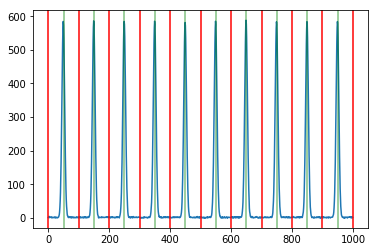

In [44]:
plt.plot(np.abs(idec + 1j*qdec))
for i in range(pulseCount+1):
    plt.axvline(i*nsamp, c='r')
    if i < pulseCount:
        plt.axvline((i+0.5)*nsamp, c='g', alpha=0.5)

In [ ]:
iaccSums = idec.reshape(-1, nsamp).sum(axis=1)
qaccSums = qdec.reshape(-1, nsamp).sum(axis=1)

di_feed = soc.tproc.single_read(addr=8)
dq_feed = soc.tproc.single_read(addr=9)
if di_feed>2**31:
    di_feed = di_feed - 2**32
if dq_feed>2**31:
    dq_feed = dq_feed - 2**32

fig,ax = plt.subplots(4,1,sharex=True)
ax[0].plot(iaccSums, "-+", label="get_decimated")
ax[0].plot(iacc, "x", label="get_accumulated")
ax[0].plot(len(iacc)-1, di_feed, "o", mfc='None', label='feedback')
ax[0].set_ylabel("I")
ax[0].legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3)

ax[1].plot(qaccSums, "-+")
ax[1].plot(qacc, "x")
ax[1].plot(len(iacc)-1, dq_feed, "o", mfc='None', label='feedback')
ax[1].set_ylabel("Q")

ax[2].plot(np.abs(iaccSums + 1j*qaccSums), "-+")
ax[2].plot(np.abs(iacc + 1j*qacc), "x")
ax[2].plot(len(iacc)-1, np.abs(di_feed + 1j*dq_feed), "o", mfc='None', label='feedback')
ax[2].set_ylabel("Amplitude")

ax[3].plot(np.arctan2(qaccSums, iaccSums), "-+")
ax[3].plot(np.arctan2(qacc, iacc), "x")
ax[3].plot(len(iacc)-1, np.arctan2(dq_feed, di_feed), "o", mfc='None', label='feedback')
ax[3].set_ylabel("$\phi$ [Rad]")

ax[3].set_xlabel("Pulse Number")

In [ ]:
print(di_feed, dq_feed)
print(iacc[-1],qacc[-1])

In [ ]:
# Make sure it works a second time.
idec,qdec,iacc,qacc = runner(pulseCount, frequency, gain, phase, address, nsamp, nsync, outputType)
di_feed = soc.tproc.single_read(addr=8)
dq_feed = soc.tproc.single_read(addr=9)
if di_feed>2**31:
    di_feed = di_feed - 2**32
if dq_feed>2**31:
    dq_feed = dq_feed - 2**32
print(di_feed, iacc[-1])
print(dq_feed, qacc[-1])
